# Run methods and plot `runtime` results

- Subsample the Heart cell atlas data [[1]](https://www.heartcellatlas.org) at various intervals, add additional continuous covariates, and select the top 4000 genes.
- Run the benchmark methods:
    - SiFT
    - regress_out
    - scVI 
- asses runtime results

[[1] Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.](https://www.heartcellatlas.org)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import anndata
import numpy as np
import pandas as pd
import time
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Set parameters

In [16]:
DATA_DIR = str(DATA_DIR) + "/runtime_hca/"
OUTPUT_DIR = str(DATA_DIR) + "/runtime_hca/output/"
FIG_DIR = str(FIG_DIR) + "/runtime_hca/"

In [5]:
import seaborn as sns
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

In [6]:
method_colors = {
    "SiFT": "#5C88DAFF", 
    "regress_out": "#84BD00FF", 
    "scVI":"#FFCD00FF", 
}

method_hatches = {
    "SiFT": "\\", 
    "regress_out": "",  
    "scVI":"", 
}

In [7]:
cont_nuisance_cov = ["percent_mito", "percent_ribo"]
bbknn_covs = ["cell_source", "donor"]

## Load data

In [ ]:
# data downloaded from: https://www.heartcellatlas.org/
adata = sc.read(DATA_DIR / 'global_raw.h5ad')

In [ ]:
adata.layers['counts'] = adata.X.copy() # move count data into a layer
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) # log the data for better umap visualization later
adata.raw = adata

## Make random nuisance covariates

In [ ]:
# make 8 random nuisance covariates
for i in range(8):
    key = 'rand_noise_{}'.format(i)
    adata.obs[key] = np.random.normal(size = adata.n_obs)
    cont_nuisance_cov+=[key]

In [ ]:
adata.write(DATA_DIR + 'hca_processed.h5ad')

## Sub-sample the data

In [ ]:
adata = sc.read(DATA_DIR + 'hca_processed.h5ad')

In [ ]:
n_obs = [5000, 10000, 20000, 40000, 80000,160000,320000,486134]
n_covs = [10]
n_vars = [4000]

#for backend mode
adata.strings_to_categoricals()
del adata.raw

for n_cov in n_covs:
    for n_ob in n_obs:
        for n_var in n_vars:
            print(f"starting {n_cov}, {n_ob}, {n_var}")
            idx = np.random.choice(adata.n_obs,n_ob,replace=False)
            tmp_adata = adata[idx].copy()
            if 'batch' in tmp_adata.obs.keys():
                del tmp_adata.obs['batch']
            tmp_adata.obs['batch'] = ''
            for cov in bbknn_covs:
                tmp_adata.obs['batch'] = tmp_adata.obs['batch'].astype(str) + tmp_adata.obs[cov].astype(str)
            
            # if one of the batches is less than 3, bbknn will fail
            while np.min(np.unique(tmp_adata.obs['batch'], return_counts=True)[1]) < 3:
                idx = np.random.choice(adata.n_obs,n_ob,replace=False)
                tmp_adata = adata[idx].copy()
                if 'batch' in tmp_adata.obs.keys():
                    del tmp_adata.obs['batch']
                tmp_adata.obs['batch'] = ''
                for cov in bbknn_covs:
                    tmp_adata.obs['batch'] = tmp_adata.obs['batch'].astype(str) + tmp_adata.obs[cov].astype(str)
            
            sc.pp.highly_variable_genes(tmp_adata,
                                        n_top_genes=n_var,
                                        subset=True,
                                        inplace=True,
                                        flavor="seurat_v3",
                                        layer='counts',
                                        batch_key="cell_source",
                                        )

            message = '{}, {}, {}, '.format(n_var, n_cov, tmp_adata.n_obs)
            
            print(message, tmp_adata.n_vars)
            scvi.model.SCVI.setup_anndata(
                tmp_adata,
                categorical_covariate_keys=bbknn_covs,
                layer="counts",
                continuous_covariate_keys=cont_nuisance_cov                
            )
            
            adata_fn = DATA_DIR + f'{n_cov}_{n_ob}_{n_var}.h5ad'

            tmp_adata.write(adata_fn)
            

## Comannds used to run each method

```bash
mprof run python run_methods.py --adata 10_5000_4000.h5ad --method sift-knn 
mprof run python run_methods.py --adata 10_10000_4000.h5ad --method sift-knn
mprof run python run_methods.py --adata 10_20000_4000.h5ad --method sift-knn
mprof run python run_methods.py --adata 10_40000_4000.h5ad --method sift-knn
mprof run python run_methods.py --adata 10_80000_4000.h5ad --method sift-knn
mprof run python run_methods.py --adata 10_160000_4000.h5ad --method sift-knn
mprof run python run_methods.py --adata 10_320000_4000.h5ad --method sift-knn
mprof run python run_methods.py --adata 10_486134_4000.h5ad --method sift-knn

mprof run python run_methods.py --adata 10_5000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_10000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_20000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_40000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_80000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_160000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_320000_4000.h5ad --method sift-rbf
mprof run python run_methods.py --adata 10_486134_4000.h5ad --method sift-rbf

mprof run python run_methods.py --adata 10_5000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_10000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_20000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_40000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_80000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_160000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_320000_4000.h5ad --method scvi
mprof run python run_methods.py --adata 10_486134_4000.h5ad --method scvi

mprof run python run_methods.py --adata 10_5000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_10000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_20000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_40000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_80000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_160000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_320000_4000.h5ad --method regress
mprof run python run_methods.py --adata 10_486134_4000.h5ad --method regress
```

## Import results

In [17]:
DATA_DIR = "/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/runtime_hca/dat_files/"
OUTPUT_DIR = "/cs/labs/mornitzan/zoe.piran/research/projects/SiFT_analysis/runtime_hca/output/"

In [10]:
def get_dat_files(DAT_DIR):
    fns = os.listdir(DAT_DIR)
    return [os.path.join(DAT_DIR,f) for f in fns if f.endswith('.dat')]

In [18]:
files = get_dat_files(DATA_DIR)

In [20]:
full = pd.DataFrame(columns=["n_var", "n_cov", "n_obs", "runtime", "mem_mb", "method"])

for i,fn in enumerate(files):
    with open(fn) as f:
        # print(fn)
        command = f.readline()
        # print(command)
        tmp = command.split(' ')
        command = tmp[-3]
        method = tmp[-1].strip()
        method_str = method
        if "sift" in method:
            method_str = method_str.split('-')
            method_str = method_str[0] + "_" + method_str[1]
        meta = command.split('_')
        
        n_cov, n_obs, n_vars = meta[0], meta[1], meta[2]
        n_cov = int(n_cov)
        n_obs = int(n_obs)
        n_vars = int(n_vars.strip()[:-5])
        time_fn = f"{n_obs}_{n_vars}_time_{method_str}.npy"
        time_fn = os.path.join(OUTPUT_DIR, time_fn)
        
        memory = []
        for line in f:
            res = line.split(" ")
            if len(res) < 2:
                print(res)
            else:
                memory.append(line.split(" ")[1])
        
        n_sec = float(np.load(time_fn))
        max_mem = np.max(np.array(memory).astype('float32'))
        full.loc[i] = [n_vars, n_cov, n_obs, n_sec, max_mem, method]
        

In [21]:
full_lim  = full[full["method"].isin(["sift-rbf", "scvi", "regress"])].copy()

In [22]:
full_lim.loc[full_lim["method"]=="sift-rbf", "method"] = "SiFT"
full_lim.loc[full_lim["method"]=="scvi", "method"] = "scVI"
full_lim.loc[full_lim["method"]=="regress", "method"] = "regress_out"


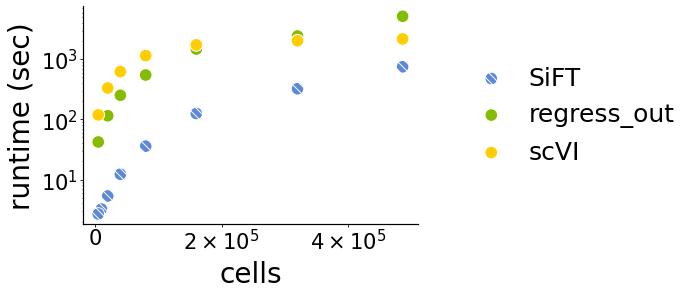

In [26]:
size = 4
fig, ax = plt.subplots(figsize=(size+2, size))

group = np.unique(full_lim['method'])


for g in np.unique(group):
    tmp = full_lim[full_lim['method']==g]
    ax.scatter(tmp['n_obs'], 
               tmp['runtime'], 
               label=g, 
               hatch=3*method_hatches[g],
               facecolor=method_colors[g],
               color="white",
               s=160,
              )

f = mticker.ScalarFormatter(useMathText=True, useOffset=True)
h = lambda x,pos : "${}$".format(f.format_data(x)) if x > 0 else "$0$"
fmt = mticker.FuncFormatter(h)

ax.set_xlabel('cells',fontsize=28)
ax.set_ylabel('runtime (sec)',fontsize=28)
ax.set_yscale('log')

ticks_loc = ax.get_xticks().tolist()
ax.set_xticks(ax.get_xticks().tolist()[1:-1])
ax.set_xticklabels([fmt(x) for x in ticks_loc[1:-1]], rotation=0,)
# ax.xaxis.set_major_formatter(f)



# ax.set_title('runtime with 4000 genes')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), )
plt.show()
# fig.savefig(FIG_DIR + f"4000_genes_runtime.png", bbox_inches="tight", dpi=DPI)